<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Caliop/Calipso" data-toc-modified-id="Caliop/Calipso-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Caliop/Calipso</a></span></li></ul></li><li><span><a href="#Read-in-the-height-and-reflectivity-fields" data-toc-modified-id="Read-in-the-height-and-reflectivity-fields-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read in the height and reflectivity fields</a></span></li><li><span><a href="#Read-in-the-heating-rate-array" data-toc-modified-id="Read-in-the-heating-rate-array-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read in the heating rate array</a></span></li><li><span><a href="#Find-the-part-of-the-orbit-that-corresponds-to-the-3-minutes-containing-the-storm" data-toc-modified-id="Find-the-part-of-the-orbit-that-corresponds-to-the-3-minutes-containing-the-storm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Find the part of the orbit that corresponds to the 3 minutes containing the storm</a></span></li><li><span><a href="#convert-time-to-distance-by-using-pyproj-to-get-the-greatcircle-distance-between-shots" data-toc-modified-id="convert-time-to-distance-by-using-pyproj-to-get-the-greatcircle-distance-between-shots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>convert time to distance by using pyproj to get the greatcircle distance between shots</a></span><ul class="toc-item"><li><span><a href="#split-out-the-long-and-shortwave-heating-rates" data-toc-modified-id="split-out-the-long-and-shortwave-heating-rates-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>split out the long and shortwave heating rates</a></span></li></ul></li><li><span><a href="#Make-the-plot-assuming-that-height-is-the-same-for-every-shot" data-toc-modified-id="Make-the-plot-assuming-that-height-is-the-same-for-every-shot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Make the plot assuming that height is the same for every shot</a></span></li></ul></div>

In [9]:
#here is a version of pdb with a few extras
from IPython.core.debugger import set_trace

# Introduction

This notebook plots the shortwave and longwave heating rates for a storm
using the [FLXHR](http://www.cloudsat.cira.colostate.edu/data-products/level-2b/2b-flxhr?term=31) product (which was not one of the 5 you were asked to download for your orbit).  As described in the [product description](http://www.cloudsat.cira.colostate.edu/sites/default/files/products/files/2B-FLXHR_PDICD.P2_R04.20071008.pdf), it combines radar and lidar measurements with a two-stream radiative transfer model to calculate the upward and downward long and shortwave fluxes
as a function of height.

## Caliop/Calipso

The [caliop lidar](https://www-calipso.larc.nasa.gov/) is an instrument on Calipso, which
is the satellite trailing directly behind cloudsat in the [afternoon constellation](https://atrain.nasa.gov/) (aka the "A-train").  It is designed to measure thin cirrus clouds and the aerosols between clouds, using laser pulses at 0.532 $\mu m$ (dual polarization) and 1.064 $\mu m$.  These "sub-visible" cirrus clouds don't precipitate, but they absorb radiation from the surface and emit relatively little to space (because they are so cold), so they're very important to the radiation budget.  If you're interested, [this article](https://www-calipso.larc.nasa.gov/resources/pdfs/Winker_etal_InitialCALIOP_2007GRL.pdf) has more detail on the mission.

#  Read in the height and reflectivity fields

In [2]:
from importlib import reload
import numpy as np
import datetime as dt
from datetime import timezone as tz
from matplotlib import pyplot as plt
import pyproj
from numpy import ma
import a301
from a301.cloudsat import get_geo
from pathlib import Path
#
# new functions to read vdata and sds arrays
#
from a301.cloudsat import HDFvd_read, HDFsd_read
plt.style.use('ggplot')

# Read in the heating rate array

its shape is (2,37082,125) with the first index = 0 for the shortwave heating
rate and 1 for the longwave heating rate.

After dividing by the scaling factor the units are (K/day).

In [3]:
hr_file= list(a301.test_dir.glob('*FLXHR*hdf'))[0]
lats,lons,date_times,prof_times,dem_elevation=get_geo(hr_file)
#
# Question: what is the purpose of squeeze()?
#
lats=lats.squeeze()
lons=lons.squeeze()
qr, qr_attrs = HDFsd_read(hr_file,'QR')
qr_height, height_attrs = HDFsd_read(hr_file,'Height')
factor = HDFvd_read(hr_file,'QR.factor',vgroup='Swath Attributes')[0][0]
missing = HDFvd_read(hr_file,'QR.missing',vgroup='Swath Attributes')[0][0]
units = HDFvd_read(hr_file,'QR.units',vgroup='Swath Attributes')[0][0]
#set_trace()
hit = (qr == missing)
qr = qr.astype(np.float64)/factor
qr[hit]=np.nan
print(units)
print(qr.shape)

K/day
(2, 37082, 125)


# Find the part of the orbit that corresponds to the 3 minutes containing the storm

You need to enter the start_hour and start_minute for the start time of your cyclone in the granule

In [4]:
def find_times(date_times,start_hour,start_minute,del_minutes):
    first_time=date_times[0]
    print(f'orbit start: {first_time}')
    storm_start=dt.datetime(first_time.year,first_time.month,first_time.day,
                                        start_hour,start_minute,0,tzinfo=tz.utc)
    #
    # get x minutes of data from the storm_start
    #
    storm_stop=storm_start + dt.timedelta(minutes=del_minutes)
    time_hit = np.logical_and(date_times > storm_start,date_times < storm_stop)
    return time_hit

start_hour=6
start_minute=45
del_minutes=3.
time_hit = find_times(date_times,start_hour,start_minute,del_minutes)


#pdb.set_trace()
storm_lats = lats[time_hit]
storm_lons=lons[time_hit]
storm_prof_times=prof_times[time_hit]
storm_qr=qr[:,time_hit,:]
storm_height=qr_height[time_hit,:]
storm_date_times=date_times[time_hit]
print(f'storm start: {storm_date_times[0]}')

orbit start: 2008-03-22 06:00:33.115000+00:00
storm start: 2008-03-22 06:45:00.155039+00:00


In [5]:
storm_qr.shape

(2, 1125, 125)

# convert time to distance by using pyproj to get the greatcircle distance between shots

In [6]:
def find_distance(storm_lons,storm_lats):
    """
    use pyproj.great_circle to turn lat/lon into surface distances
    
    Parameters
    ----------
    
    storm_lons: float array 
          longitudes in deg E
    
    stom_lats: float array
          latitudes in deg N
          
    Returns
    -------
    
    distance: float array
        Great circle distances between each (lon,lat) pair in km
    """
    meters2km=1.e3
    great_circle=pyproj.Geod(ellps='WGS84')
    distance=[0]
    start=(storm_lons[0],storm_lats[0])
    for index in np.arange(1,len(storm_lons)):
        azi12,azi21,step= great_circle.inv(storm_lons[index-1],storm_lats[index-1],
                                           storm_lons[index],storm_lats[index])
        distance.append(distance[index-1] + step)
    distance=np.array(distance)/meters2km
    return distance

distance=find_distance(storm_lons,storm_lats)

## split out the long and shortwave heating rates

In [7]:
shortwave_qr=storm_qr[0,:,:]
longwave_qr=storm_qr[1,:,:]

# Make the plot assuming that height is the same for every shot

We need to customize the subplots so we can share the x axis and drop the colorbar
in below the plots

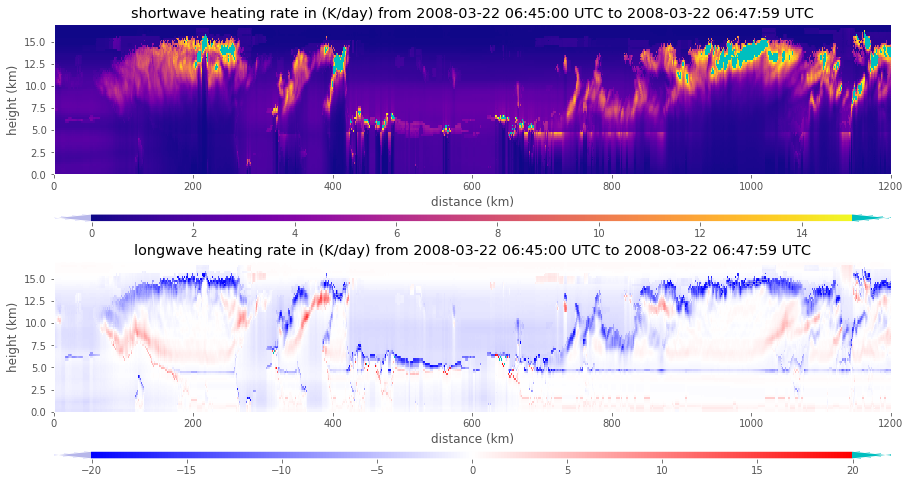

In [8]:
%matplotlib inline

from matplotlib import cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_field2(distance,height,field,fig,cmap=None,norm=None):
    """
    draw a 2 panel plot with identical panel sizes.  
    uses the sharex keyword to give both plots the same x axis (distance) 
    and the gridspec class to lay out the grid
    
    https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
    """
    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1],sharex=ax1)
    if cmap is None:
        cmap=cm.inferno
    col=ax1.pcolormesh(distance,height,field,cmap=cmap,
                  norm=the_norm)
    #https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    # create an axes on the bottom side of ax1. The height of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.55 inch.
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("bottom", size="5%", pad=0.55)
    ax1.figure.colorbar(col,extend='both',cax=cax,orientation='horizontal')
    return ax1, ax2

meters2km=1.e3
vmin=0
vmax=15
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap_ref=cm.plasma
cmap_ref.set_over('c')
cmap_ref.set_under('b',alpha=0.2)
cmap_ref.set_bad('0.75') #75% grey
#
#  see http://strftime.org/ for these format strings
#
start_string=storm_date_times[0].strftime("%Y-%m-%d %H:%M:%S UTC")
stop_string=storm_date_times[-1].strftime("%Y-%m-%d %H:%M:%S UTC")

cloud_height_km=qr_height[0,:]/meters2km
fig = plt.figure(figsize=(15, 8)) 
ax1, ax2 = plot_field2(distance,cloud_height_km,shortwave_qr.T,
                       fig,cmap=cmap_ref,norm=the_norm)
ax1.set(ylim=[0,17],xlim=(0,1200))
ax1.set(xlabel='distance (km)',ylabel='height (km)',
       title=f'shortwave heating rate in (K/day) from {start_string} to '
             f'{stop_string}');
vmin=-20
vmax=20.
cmap_ref=cm.bwr
cmap_ref.set_over('c')
cmap_ref.set_under('b',alpha=0.2)
cmap_ref.set_bad('0.75') #75% grey
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.55)
col=ax2.pcolormesh(distance,cloud_height_km,longwave_qr.T,cmap=cmap_ref,
                  norm=the_norm)
ax2.figure.colorbar(col,extend='both',cax=cax,orientation='horizontal')
title = (f'longwave heating rate in (K/day) from {start_string} to '
         f'{stop_string}')
ax2.set(xlabel='distance (km)',ylabel='height (km)',title=title,ylim=[0,17]);

Summary -- clouds are heating in the shortwave, cooing in the longwave at rates that are about 3 times larger
than the surrounding atmosphere.

**Question: How did the Cloudsat science team get these estimates?**

We go over this in the Schwartzchild heating rate notes.